
=== ANALYSIS COMPLETE ===
Files saved to your desktop:
- risk_section.txt
- identified_risks.txt
- risk_evaluation_methods.txt
- risk_categories.png
- risk_terms_wordcloud.png
- disney_risk_factors.csv
- risk_analysis_summary.txt

SUMMARY:
- Identified 5 individual risk factors
- Top risk categories:
  * Economic: 4 risks
  * Operations: 3 risks
  * International: 3 risks
- Found 4 mentions of risk evaluation approaches
- Most common risk terms:
  * company: 45 occurrences
  * foreign: 29 occurrences
  * interest: 28 occurrences
  * september: 23 occurrences
  * rate: 22 occurrences


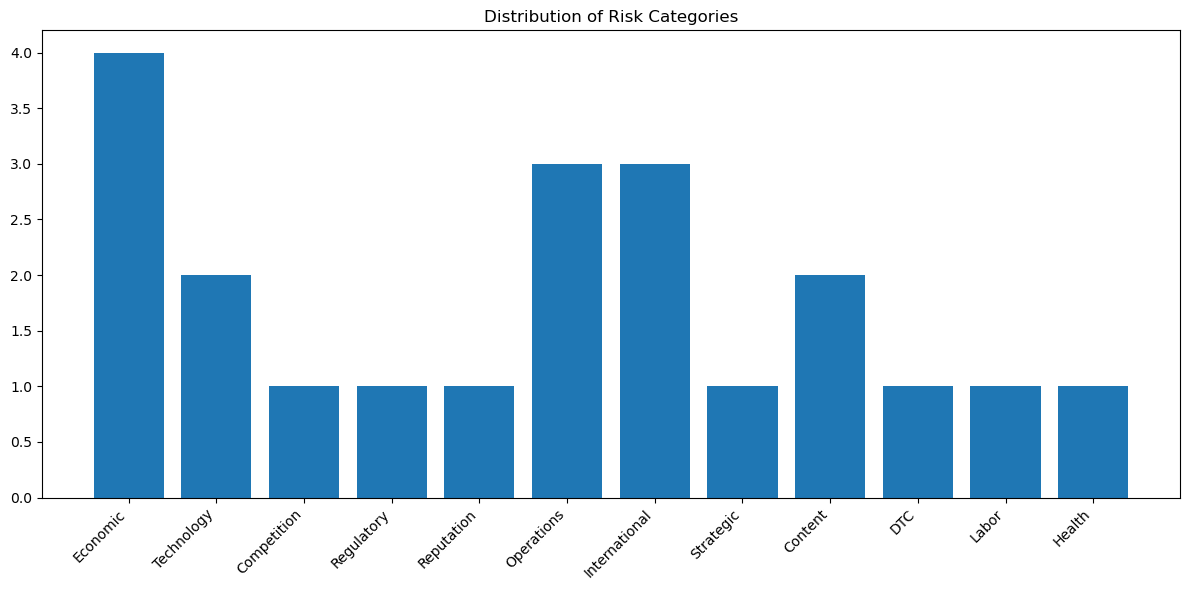

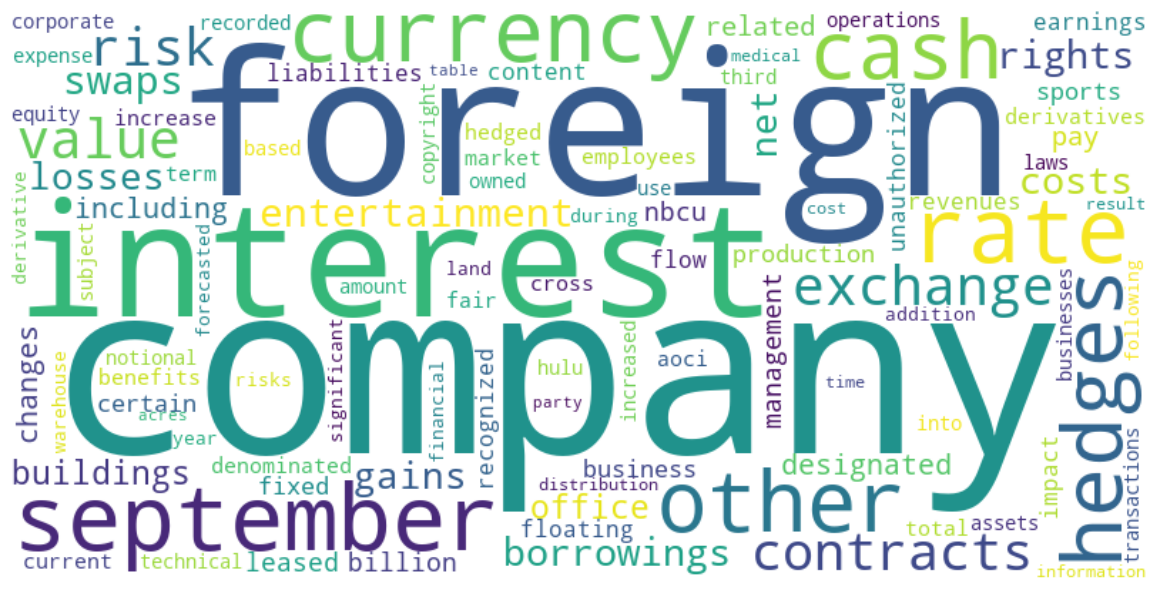

In [5]:
import PyPDF2
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import os

def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        num_pages = len(reader.pages)

        # Extract text from each page
        for page_num in range(num_pages):
            page = reader.pages[page_num]
            page_text = page.extract_text()
            text += page_text + "\n\n"

    return text

def extract_risk_factors_section(text):
    # Try standard pattern first
    pattern = r'ITEM 1A\.\s*Risk\s*Factors(.*?)ITEM 1B\.'
    match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
    if match and len(match.group(1).strip()) > 200:
        return match.group(1).strip()

    # Try alternative patterns
    alt_patterns = [
        r'Item\s*1A\.\s*Risk\s*Factors(.*?)Item\s*1B\.',
        r'RISK\s*FACTORS(.*?)ITEM\s*1B\.',
        r'Risk\s*Factors(.*?)UNRESOLVED'
    ]

    for pattern in alt_patterns:
        match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
        if match and len(match.group(1).strip()) > 200:
            return match.group(1).strip()

    # Find sections with highest concentration of risk-related terms
    chunks = [text[i:i + 10000] for i in range(0, len(text), 10000)]
    risk_scores = []

    for chunk in chunks:
        score = (chunk.lower().count('risk') * 3 +
                 chunk.lower().count('uncertain') * 2 +
                 chunk.lower().count('factor') +
                 chunk.lower().count('adverse'))
        risk_scores.append(score)

    if max(risk_scores) > 10:
        # Get the top 3 chunks with highest risk scores
        best_indices = sorted(range(len(risk_scores)), key=lambda i: risk_scores[i], reverse=True)[:3]
        best_chunks = [chunks[i] for i in best_indices]
        return "\n\n".join(best_chunks)

    pages = text.split("\n\n")
    middle_section = "\n\n".join(pages[len(pages) // 3:2 * len(pages) // 3])  # Middle third of document

    return middle_section

def extract_risks(risk_section):
    risks = []
    # Method 1: Look for capitalized headers that typically indicate new risk factors
    header_patterns = [
        r'([A-Z][A-Z\s,]+[A-Z][\.:])',  # ALL CAPS HEADERS
        r'([A-Z][a-z]+(?:\s+[A-Z][a-z]+){2,}[\.:])',  # Title Case Headers
        r'(\n[A-Z][^\.]{10,60}\.)'  # New line, starts with capital, ends with period
    ]

    for pattern in header_patterns:
        headers = re.findall(pattern, risk_section)

        if len(headers) >= 3:
            for i, header in enumerate(headers):
                start_pos = risk_section.find(header)
                if i < len(headers) - 1:
                    next_header = headers[i + 1]
                    end_pos = risk_section.find(next_header)
                    risk_content = risk_section[start_pos:end_pos].strip()
                else:
                    # For the last header, take a reasonable amount of text
                    end_pos = min(start_pos + 2000, len(risk_section))
                    risk_content = risk_section[start_pos:end_pos].strip()

                if len(risk_content) > 100:
                    risks.append(risk_content)

    # Method 2: Look for paragraphs containing risk-related terms
    if len(risks) < 5:
        paragraphs = [p.strip() for p in re.split(r'\n\s*\n', risk_section) if p.strip()]

        for p in paragraphs:
            if len(p) > 150 and re.search(r'\b(risk|impact|affect|disrupt|uncertain|challenge|adverse)\b', p,
                                          re.IGNORECASE):
                risks.append(p)

    # Method 3: Split content based on risk-related sentences
    if len(risks) < 5:
        sentences = re.split(r'(?<=[.!?])\s+', risk_section)
        risk_sentences = []
        current_risk = ""

        for sentence in sentences:
            current_risk += sentence + " "
            if re.search(r'\b(risk|impact|adverse|materially|negatively|affect)\b', sentence, re.IGNORECASE):
                if len(current_risk) > 200:
                    risk_sentences.append(current_risk.strip())
                    current_risk = ""

        if current_risk:
            risk_sentences.append(current_risk.strip())

        risks.extend(risk_sentences)

    # Remove duplicates and highly similar risks
    unique_risks = []
    for risk in risks:
        is_unique = True
        for existing in unique_risks:
            # Check for similarity by looking at overlapping content
            smaller = min(len(risk), len(existing))
            similarity = sum(1 for a, b in zip(risk[:smaller], existing[:smaller]) if a == b) / smaller
            if similarity > 0.7:  # If more than 70% similar
                is_unique = False
                break

        if is_unique:
            unique_risks.append(risk)

    return unique_risks

def extract_risk_evaluation_methods(risk_section):
    evaluation_methods = []
    # Look for sentences mentioning risk management/evaluation
    sentences = re.split(r'(?<=[.!?])\s+', risk_section)
    for sentence in sentences:
        # Check if sentence relates to risk management
        if re.search(r'\b(evaluat|assess|measur|mitigat|manag|monitor|identify|analyze)\b', sentence, re.IGNORECASE) and \
                re.search(r'\brisk', sentence, re.IGNORECASE):
            if len(sentence) > 20:  # Avoid very short fragments
                evaluation_methods.append(sentence)

    return evaluation_methods


def categorize_risks(risks):
    categories = {
        "Economic": ["economic", "recession", "inflation", "market", "financial", "cost", "price", "revenue"],
        "Technology": ["technology", "technological", "digital", "cybersecurity", "data", "IT", "cyber"],
        "Competition": ["competition", "competitive", "competitor", "market share", "alternative"],
        "Regulatory": ["regulatory", "regulation", "law", "legal", "compliance", "governance"],
        "Reputation": ["reputation", "brand", "image", "public perception"],
        "Operations": ["operations", "operational", "supply chain", "disruption", "infrastructure"],
        "International": ["international", "global", "foreign", "currency", "exchange rate"],
        "Strategic": ["strategy", "strategic", "business plan", "investment", "acquisition"],
        "Content": ["content", "entertainment", "programming", "creative", "media"],
        "DTC": ["DTC", "streaming", "direct-to-consumer", "subscription", "subscriber"],
        "Labor": ["labor", "workforce", "employee", "talent", "personnel"],
        "Health": ["health", "pandemic", "COVID", "disease", "illness"]
    }

    risk_categories = {category: [] for category in categories}

    for risk in risks:
        for category, keywords in categories.items():
            for keyword in keywords:
                if re.search(r'\b' + keyword + r'\b', risk, re.IGNORECASE):
                    risk_categories[category].append(risk)
                    break

    return risk_categories


def extract_key_terms(risks):
    # Join all risks
    all_text = " ".join(risks)

    # Define stop words
    stop_words = set([
        "the", "and", "a", "to", "of", "our", "in", "for", "on", "with", "as", "by", "or",
        "that", "be", "this", "we", "are", "is", "an", "it", "its", "from", "at", "which",
        "have", "has", "not", "these", "such", "may", "could", "would", "should", "can",
        "their", "they", "them", "been", "being", "were", "was", "will", "more", "some"
    ])

    # Use regex to tokenize
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text)
    words = [w.lower() for w in words if w.lower() not in stop_words]

    # Count frequencies
    word_counts = Counter(words)

    return word_counts

def generate_visualizations(risk_categories, word_counts, desktop_path):
    # 1. Risk category distribution
    categories = list(risk_categories.keys())
    counts = [len(risks) for risks in risk_categories.values()]

    plt.figure(figsize=(12, 6))
    plt.bar(categories, counts)
    plt.title('Distribution of Risk Categories')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(desktop_path, 'risk_categories.png'))

    # 2. Word cloud of key terms
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, collocations=False).generate_from_frequencies(
        dict(word_counts.most_common(100)))

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(desktop_path, 'risk_terms_wordcloud.png'))

def analyze_risks_summary(risks, risk_categories, evaluation_methods, word_counts):
    summary = {}

    # Number of risks identified
    summary["total_risks"] = len(risks)

    # Distribution of risks by category
    summary["category_distribution"] = {category: len(category_risks) for category, category_risks in
                                        risk_categories.items()}

    # Top categories by number of risks
    top_categories = sorted(summary["category_distribution"].items(), key=lambda x: x[1], reverse=True)
    summary["top_categories"] = top_categories[:5] if len(top_categories) > 5 else top_categories

    # Risk evaluation approach summary
    summary["evaluation_methods_count"] = len(evaluation_methods)

    # Top risk terms
    summary["top_terms"] = word_counts.most_common(20)

    # Average risk length
    summary["avg_risk_length"] = sum(len(risk) for risk in risks) / len(risks) if risks else 0

    return summary

def analyze_disney_risks(pdf_path):
    desktop_path = r""

    # 1. Extract text from PDF
    document_text = extract_text_from_pdf(pdf_path)

    # 2. Extract risk factors section
    risk_section = extract_risk_factors_section(document_text)

    # Save the risk section
    with open(os.path.join(desktop_path, "risk_section.txt"), "w", encoding="utf-8") as f:
        f.write(risk_section)

    # 3. Extract individual risks
    risks = extract_risks(risk_section)

    # Save risks to a text file
    with open(os.path.join(desktop_path, "identified_risks.txt"), "w", encoding="utf-8") as f:
        for i, risk in enumerate(risks):
            f.write(f"RISK {i + 1}:\n{risk}\n\n{'=' * 80}\n\n")

    # 4. Analyze how Disney evaluates risks
    evaluation_methods = extract_risk_evaluation_methods(risk_section)

    # Save evaluation methods
    with open(os.path.join(desktop_path, "risk_evaluation_methods.txt"), "w", encoding="utf-8") as f:
        for i, method in enumerate(evaluation_methods):
            f.write(f"METHOD {i + 1}:\n{method}\n\n")

    # 5. Categorize risks
    risk_categories = categorize_risks(risks)

    # 6. Extract key terms
    word_counts = extract_key_terms(risks)

    # 7. Generate visualizations
    generate_visualizations(risk_categories, word_counts, desktop_path)

    # 8. Create a detailed report
    risk_df = pd.DataFrame({
        "Risk Factor": risks,
        "Length": [len(risk) for risk in risks],
        "Word Count": [len(risk.split()) for risk in risks]
    })

    # Add category labels
    for category, category_risks in risk_categories.items():
        risk_df[category] = risk_df["Risk Factor"].apply(lambda x: x in category_risks)

    # Save to CSV
    risk_df.to_csv(os.path.join(desktop_path, "disney_risk_factors.csv"), index=False)

    # 9. Create summary analysis
    summary = analyze_risks_summary(risks, risk_categories, evaluation_methods, word_counts)

    # Create summary report
    with open(os.path.join(desktop_path, "risk_analysis_summary.txt"), "w", encoding="utf-8") as f:
        f.write("=== DISNEY 10-K RISK ANALYSIS SUMMARY ===\n\n")
        f.write(f"Total Risk Factors Identified: {summary['total_risks']}\n")
        f.write(f"Average Risk Length: {summary['avg_risk_length']:.1f} characters\n\n")

        f.write("Top Risk Categories:\n")
        for category, count in summary['top_categories']:
            f.write(f"- {category}: {count} risks\n")
        f.write("\n")

        f.write("Risk Evaluation Methods:\n")
        f.write(f"- Found {summary['evaluation_methods_count']} mentions of risk evaluation/management\n\n")

        f.write("Top Risk Terms:\n")
        for term, count in summary['top_terms'][:10]:
            f.write(f"- {term}: {count} occurrences\n")

        f.write("\n=== FILES GENERATED ===\n")
        f.write("- risk_section.txt: Raw risk factors section extracted from 10-K\n")
        f.write("- identified_risks.txt: Individual risk factors identified\n")
        f.write("- risk_evaluation_methods.txt: How Disney evaluates and manages risks\n")
        f.write("- risk_categories.png: Visual distribution of risk categories\n")
        f.write("- risk_terms_wordcloud.png: Word cloud of most common risk terms\n")
        f.write("- disney_risk_factors.csv: Detailed analysis of all risk factors\n")

    print("\n=== ANALYSIS COMPLETE ===")
    print("Files saved to your desktop:")
    print("- risk_section.txt")
    print("- identified_risks.txt")
    print("- risk_evaluation_methods.txt")
    print("- risk_categories.png")
    print("- risk_terms_wordcloud.png")
    print("- disney_risk_factors.csv")
    print("- risk_analysis_summary.txt")

    # Print summary statistics
    print("\nSUMMARY:")
    print(f"- Identified {summary['total_risks']} individual risk factors")
    print("- Top risk categories:")
    for category, count in summary['top_categories'][:3]:
        print(f"  * {category}: {count} risks")
    print(f"- Found {summary['evaluation_methods_count']} mentions of risk evaluation approaches")
    print("- Most common risk terms:")
    for term, count in summary['top_terms'][:5]:
        print(f"  * {term}: {count} occurrences")


if __name__ == "__main__":
    pdf_path = r"2024-Annual-Report.pdf"
    analyze_disney_risks(pdf_path)